<a href="https://colab.research.google.com/github/HeikoViel/advancedhpc2023/blob/main/labwork8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numba
from numba import cuda
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
image = plt.imread("frog.jpg")
x_pixel = image.shape[0]
y_pixel = image.shape[1]
image = image.reshape(x_pixel * y_pixel, 3)

In [29]:
@cuda.jit
def RGBtoHSV(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  R = src[tidx, 0] / 255
  G = src[tidx, 1] / 255
  B = src[tidx, 2] / 255
  if(R >= G and R >= B):
    listMax = R
  if(G >= B and G >= R):
    listMax = G
  if(B >= R and B >= G):
    listMax = B
  if(R <= G and R <= B):
    listMin = R
  if(G <= B and G <= R):
    listMin = G
  if(B <= R and B <= G):
    listMin = B
  delta = listMax - listMin
  if(delta==0):
    dst[tidx, 0] = 0
  elif(R==listMax):
    dst[tidx, 0] = 60 * (((G - B)/delta)%6)
  elif(G==listMax):
    dst[tidx, 0] = 60 * ((B-R)/delta + 2)
  elif(B==listMax):
    dst[tidx, 0] = 60 * ((R-G)/delta + 4)

  if(listMax!=0):
    dst[tidx, 1] = delta/listMax
  else:
    dst[tidx, 1] = 0

  dst[tidx, 2] = listMax

In [53]:
@cuda.jit
def HSVtoRGB(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  V = src[tidx, 2]
  S = src[tidx, 1]
  H = src[tidx, 0]
  d = H / 60
  hi = (int)(d%6)
  f = d - hi
  l = V * (1 - S)
  m = V * (1 - f * S)
  n = V * (1 - (1 - f))

  if(0 <= H < 60):
    dst[tidx, 0] = V
    dst[tidx, 1] = n
    dst[tidx, 2] = l
  elif(60 <= H < 120):
    dst[tidx, 0] = m
    dst[tidx, 1] = V
    dst[tidx, 2] = l
  elif(120 <= H < 180):
    dst[tidx, 0] = l
    dst[tidx, 1] = V
    dst[tidx, 2] = n
  elif(180 <= H < 240):
    dst[tidx, 0] = l
    dst[tidx, 1] = m
    dst[tidx, 2] = V
  elif(240 <= H < 300):
    dst[tidx, 0] = n
    dst[tidx, 1] = l
    dst[tidx, 2] = V
  elif(300 <= H < 360):
    dst[tidx, 0] = V
    dst[tidx, 1] = l
    dst[tidx, 2] = m

  dst[tidx, 0] = int(dst[tidx, 0] * 255)
  dst[tidx, 1] = int(dst[tidx, 1] * 255)
  dst[tidx, 2] = int(dst[tidx, 2] * 255)

In [56]:
print(image[0])
devSrc = cuda.to_device(image)
devDst = cuda.device_array((x_pixel * y_pixel, 3), np.float32)
pixelCount = x_pixel * y_pixel
blockSize = 64
gridSize = np.uint16(pixelCount / blockSize)
RGBtoHSV[gridSize, blockSize](devSrc, devDst)

[ 96 109  63]


[0 0 0]


(-0.5, 745.5, 738.5, -0.5)

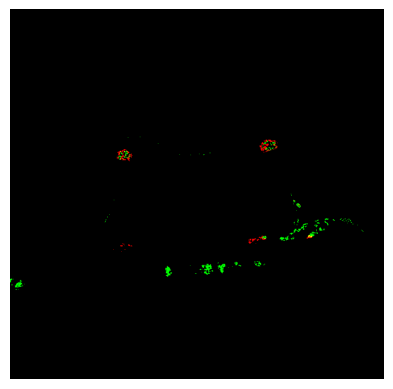

In [57]:
#devSrc2 = cuda.to_device(hostDst)
devDst2 = cuda.device_array((x_pixel * y_pixel, 3), np.uint8)
HSVtoRGB[gridSize, blockSize](devDst, devDst2)
hostDst = devDst2.copy_to_host()

print(hostDst[0])

hostDst = hostDst.reshape(x_pixel, y_pixel, 3)
fig, ax = plt.subplots()
ax.imshow(hostDst)
ax.axis('off')